In [1]:
# Block 1
# Imports


import tensorflow as tf
import numpy as np

import json
import glob
import os
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorboard
import matplotlib.pyplot as plt

import datetime

In [27]:
# Block 2
# Loader


class Loader:
    def __init__(self, problems_path, submissions_dir, log_dir, max_length, batch_size):
        self.problems_path = problems_path
        self.submissions_dir = submissions_dir
        self.max_length = max_length
        self.batch_size = batch_size

        self.problem_tokenizer = Tokenizer(filters='')
        self.solution_tokenizer = Tokenizer(filters='', oov_token='UNK')
        self.dataset = None
        
        self.writer = tf.summary.create_file_writer(log_dir)

    def _load_problems_and_solutions(self):
        # Load problems
        with open(self.problems_path, 'r') as problems_file:
            problems_list = json.load(problems_file)
        raw_problems = {}
        
        for problem in problems_list:
            problem_id = problem['problem_id']
            concatenated_problem = "XXSTATEMENT {} XXINPUT {} XXOUTPUT {} XXNOTES {} XXEXAMPLES {}".format(
                problem.get('problem_statement', ''),
                problem.get('problem_input', ''),
                problem.get('problem_output', ''),
                problem.get('problem_notes', ''),
                problem.get('examples', '')
            )
            raw_problems[problem_id] = concatenated_problem
            
        # Load solutions
        raw_solutions = [[] for _ in range(len(raw_problems) * 2)] # Estimate allows us to delete up to half
        submissions = glob.glob(os.path.join(self.submissions_dir, "*.py"))
        
        for submission_path in submissions:
            problem_number = int(re.findall(r'^\d+', os.path.basename(submission_path))[0])
            with open(submission_path, "r") as f:
                solutionList = []
                for token in tokenize.generate_tokens(f.readline):
                    solutionList.append(token.string)
                raw_solutions[problem_number].append(solutionList)
        
        # Flatten problems and solutions
        problems = []
        solutions = []
        for problem_id, solution_set in enumerate(raw_solutions):
            if solution_set:
                for solution in solution_set:
                    problems.append(raw_problems[problem_id])
                    solutions.append(solution)

        return problems, solutions

    def tokenize_and_pad(self, problems, solutions):
        self.problem_tokenizer.fit_on_texts(problems)
        self.solution_tokenizer.fit_on_texts(solutions)

        problem_sequences = self.problem_tokenizer.texts_to_sequences(problems)
        solution_sequences = self.solution_tokenizer.texts_to_sequences(solutions)
        print(solutions[0])
        print(solution_sequences[0])

        problems_padded = pad_sequences(problem_sequences, padding='post', maxlen=self.max_length)
        solutions_padded = pad_sequences(solution_sequences, padding='post', maxlen=self.max_length)
        
        print(problems_padded)
        print("taco")
        for l in solutions_padded:
            print(l)
        return problems_padded, solutions_padded
    
    def _create_tf_dataset(self, problem_padded, solution_padded):
        # Prepare decoder input (shifted solution)
        decoder_input = tf.pad(solution_padded, [[0, 0], [1, 0]])[:, :-1]  # Shift left

        # Ground truth
        target = solution_padded

        # Create the dataset
        dataset = tf.data.Dataset.from_tensor_slices(((problem_padded, decoder_input), target))
        
        return dataset.shuffle(buffer_size=1024).batch(self.batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    def _log_dataset_samples(self, problem_padded, solution_padded):
        with self.writer.as_default():
            for i, (problem, solution) in enumerate(zip(problem_padded, solution_padded)):
                if i >= 5:  # Log just 5 samples
                    break
                problem_text = self.problem_tokenizer.sequences_to_texts([problem])[0]
                solution_text = self.solution_tokenizer.sequences_to_texts([solution])[0]

                tf.summary.text(name=f"Problem_{i}", data=problem_text, step=0)
                tf.summary.text(name=f"Solution_{i}", data=solution_text, step=0)
            
            self.writer.flush()
            
    def load_data(self):
        problems, solutions = self._load_problems_and_solutions()

        problems_padded, solutions_padded = self.tokenize_and_pad(problems, solutions)
        self._log_dataset_samples(problems_padded, solutions_padded)
        self.dataset = self._create_tf_dataset(problems_padded, solutions_padded)

In [19]:
# Block 3
# Positional Encoder

def positional_encoder(seq_length, d_model):
    # Generate positions for each element
    positions = tf.range(seq_length, dtype=tf.float32)[..., tf.newaxis]

    # Create a range for the dimensions and compute division terms
    # Uses geometric progression with a base of 10,000; the rate depends on the dimension
    i = tf.range(d_model, dtype=tf.float32)
    div_terms = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))

    # Calculate odd/even sinusoidal encodings
    angle_rates = positions * div_terms
    sine = tf.sin(angle_rates[:, 0::2])
    cosine = tf.cos(angle_rates[:, 1::2])

    # Interlace and reshape
    pos_encoding = tf.reshape(tf.concat([sine, cosine], axis=-1), [1, seq_length, d_model])

    return pos_encoding

In [20]:
# Block 4
# Encoder/Decoder Layer classes

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, dim_ff, dim, num_heads, dropout_rate, name="EncoderLayer"):
        super(EncoderLayer, self).__init__(name=name)

        # Multi-Head Self-Attention layer
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

        # Feed-Forward Network Layers
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dim_ff, activation='relu', kernel_initializer='he_normal', name="encoder_ffn_dense1"),
            tf.keras.layers.Dense(dim, kernel_initializer='he_normal', name="encoder_ffn_dense2")
        ], name="encoder_ffn")

        # Normalization Layers
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="encoder_layernorm1")
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="encoder_layernorm2")

        # Dropout
        self.dropout_mha = tf.keras.layers.Dropout(dropout_rate)
        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        # Self-Attention
        attn_output = self.mha(x, x)  # Self attention
        attn_output = self.dropout_mha(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Residual connection

        # Feed-Forward Network
        ffn_input = self.layernorm2(out1)
        ffn_out = self.ffn(ffn_input)
        ffn_out = self.dropout_ffn(ffn_out, training=training)
        out2 = out1 + ffn_out  # Residual connection

        return out2

    def get_config(self):
        config = super(EncoderLayer, self).get_config()
        mha_config = self.mha.get_config()  # Won't work if mha1 and mha2 are different
        config.update({
            "dim_ff": self.ffn.layers[0].units,
            "num_heads": mha_config['num_heads'], 
            "key_dim": mha_config['key_dim'], 
            "dropout_rate": self.dropout_mha.rate
        })
        return config


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, dim_ff, dim, num_heads, dropout_rate, name="DecoderLayer"):
        super(DecoderLayer, self).__init__(name=name)

        # Self-Attention and Cross-Attention layers
        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

        # Feed Forward Network Layers
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dim_ff, activation='relu', kernel_initializer='he_normal', name="decoder_ffn_dense1"),
            tf.keras.layers.Dense(dim, kernel_initializer='he_normal', name="decoder_ffn_dense2")
        ], name="decoder_ffn")

        # Normalization Layers
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="decoder_layernorm1")
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="decoder_layernorm2")
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="decoder_layernorm3")

        # Dropout
        self.dropout_self_attn = tf.keras.layers.Dropout(dropout_rate)
        self.dropout_cross_attn = tf.keras.layers.Dropout(dropout_rate)
        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):
        # Self-Attention
        attn1_output = self.mha1(x, x, attention_mask=look_ahead_mask)
        attn1_output = self.dropout_self_attn(attn1_output, training=training)
        out1 = self.layernorm1(x + attn1_output)  # Residual connection

        # Cross-Attention
        attn2_output = self.mha2(out1, enc_output, attention_mask=padding_mask)
        attn2_output = self.dropout_cross_attn(attn2_output, training=training)
        out2 = self.layernorm2(out1 + attn2_output)  # Residual connection

        # Feed-Forward Network
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout_ffn(ffn_out, training=training)
        out3 = self.layernorm3(ffn_out + out2)  # Residual connection

        return out3

    def get_config(self):
        config = super(DecoderLayer, self).get_config()
        mha1_config = self.mha1.get_config()  # Won't work if mha1 and mha2 are different
        config.update({
            "dim_ff": self.ffn.layers[0].units,
            "num_heads": mha1_config['num_heads'], 
            "key_dim": mha1_config['key_dim'], 
            "dropout_rate": self.dropout_self_attn.rate
        })
        return config

In [21]:
# Block 5
# Transformer

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, dim, dim_ff, key_dim, num_heads, num_layers, dropout_rate, name="TransformerEncoder"):
        super(TransformerEncoder, self).__init__(name=name)
        self.num_layers = num_layers
        self.enc_layers = [EncoderLayer(dim_ff, dim, num_heads, dropout_rate, name=f"encoder_layer_{i}") for i in range(num_layers)]

    def call(self, x: tf.Tensor, training=False) -> tf.Tensor:
        for layer in self.enc_layers:
            x = layer(x, training=training)
        return x


class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, dim, dim_ff, key_dim, num_heads, num_layers, dropout_rate, name="TransformerDecoder"):
        super(TransformerDecoder, self).__init__(name=name)
        self.num_layers = num_layers
        self.dec_layers = [DecoderLayer(dim_ff, dim, num_heads, dropout_rate, name=f"decoder_layer_{i}") for i in range(num_layers)]

    def call(self, x: tf.Tensor, enc_output: tf.Tensor, training=False) -> tf.Tensor:
        for layer in self.dec_layers:
            x = layer(x, enc_output, training=training)
        return x


class Transformer(tf.keras.Model):
    def __init__(self, dim, dim_ff, key_dim, problem_vocab_size, solution_vocab_size, num_heads, num_layers, dropout_rate):
        super(Transformer, self).__init__()
        self.dim = dim
        
        # Separate embedding for input and output
        self.problem_embedding_layer = tf.keras.layers.Embedding(problem_vocab_size, dim)
        self.solution_embedding_layer = tf.keras.layers.Embedding(solution_vocab_size, dim)

        self.encoder = TransformerEncoder(dim, dim_ff, key_dim, num_heads, num_layers, dropout_rate, name="encoder")
        self.decoder = TransformerDecoder(dim, dim_ff, key_dim, num_heads, num_layers, dropout_rate, name="decoder")

        self.final_layer = tf.keras.layers.Dense(solution_vocab_size, name="output_layer")

    def call(self, encoder_input, decoder_input, training=False):
        encoder_emb = self.problem_embedding_layer(encoder_input)
        decoder_emb = self.solution_embedding_layer(decoder_input)

        seq_length_enc = tf.shape(encoder_input)[1]
        seq_length_dec = tf.shape(decoder_input)[1]
        pos_encoding_enc = positional_encoder(seq_length_enc, self.dim)
        pos_encoding_dec = positional_encoder(seq_length_dec, self.dim)

        encoder_emb += pos_encoding_enc
        decoder_emb += pos_encoding_dec

        encoder_output = self.encoder(encoder_emb, training=training)
        decoder_output = self.decoder(decoder_emb, encoder_output, training=training)

        final_output = self.final_layer(decoder_output)

        return final_output
    

In [22]:
# Block 6
# Build and Compile

def build_and_compile(dim, dim_ff, key_dim, nhead, num_layers, problem_vocab_size, solution_vocab_size, dropout_rate, learning_rate=1e-4):
    # Define model inputs
    encoder_input = tf.keras.Input(shape=(None,), dtype='int32', name='encoder_input')
    decoder_input = tf.keras.Input(shape=(None,), dtype='int32', name='decoder_input')

    # Initialize and call the Transformer
    transformer = Transformer(dim, dim_ff, key_dim, problem_vocab_size, solution_vocab_size, nhead, num_layers, dropout_rate)
    final_output = transformer(encoder_input, decoder_input)

    # Create the model
    model = tf.keras.Model(inputs=[encoder_input, decoder_input], outputs=final_output)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [23]:
# Block 7
# Define Training Steps

def calculate_loss(model_output, tokenized_code, mask):
    loss = tf.keras.losses.sparse_categorical_crossentropy(tokenized_code, model_output, from_logits=True)
    loss *= mask  # Apply mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

@tf.function
def train_step(model, optimizer, tokenized_question, tokenized_code, clip_norm=1.0):
    with tf.GradientTape() as tape:
        model_output = model([tokenized_question, tokenized_code], training=True)

        # Mask PAD tokens
        mask = tf.cast(tf.math.logical_not(tf.math.equal(tokenized_code, 0)), dtype=model_output.dtype)
        
        # Calculate loss
        average_loss = calculate_loss(model_output, tokenized_code, mask)

    # Compute and clip gradients
    gradients = tape.gradient(average_loss, model.trainable_variables)
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, clip_norm)

    # Apply gradients to update model weights
    optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))

    return average_loss

In [28]:
# Block 8
# Execution

if __name__ == "__main__":
    # Paths to data
    #problems_path = "/workspace/Training_Data/A_Problems.json"
    #submissions_dir = "/workspace/Training_Data/A_Submissions_4"
    #log_dir = "/workspace/logs"

    problems_path = "C:/AIClub/Training_Data_Cleaned/A_Problems.json"
    submissions_dir = "C:/AIClub/Training_Data_Cleaned/A_Submissions"
    log_dir = "C:/AIClub/logs"

    # Set hyperparameters
    dim = 256
    dim_ff = dim * 4
    num_layers = 6
    num_heads = 8
    key_dim = dim // num_heads

    max_length = 530 # Set to cover about 85% of inputs
    dropout_rate = 0.01 # Lowered temporarily

    batch_size = 16
    learning_rate = 0.002
    epochs = 1

    assert dim % num_heads == 0, "dim % num_heads != 0"

    # Initialize the Loader
    loader = Loader(problems_path, submissions_dir, log_dir, max_length, batch_size)
    loader.load_data()
    problem_vocab_size = len(loader.problem_tokenizer.word_index) + 1
    solution_vocab_size = len(loader.solution_tokenizer.word_index) + 1
    
    # Build the model
    model = build_and_compile(dim, dim_ff, key_dim, num_heads, num_layers, problem_vocab_size, solution_vocab_size, dropout_rate, learning_rate)

    # Setup TensorBoard callback
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Train the model
    history = model.fit(loader.dataset, epochs=epochs, callbacks=[tensorboard_callback])

    # Save the model
    model.save("/workspace")

['a', '=', 'input', '(', ')', '.', 'lower', '(', ')', ';', 'b', '=', 'input', '(', ')', '.', 'lower', '(', ')', ';', 'print', '(', '(', 'a', '>', 'b', ')', '-', '(', 'a', '<', 'b', ')', ')', '', '']
[20, 6, 12, 3, 4, 17, 74, 3, 4, 82, 28, 6, 12, 3, 4, 17, 74, 3, 4, 82, 15, 3, 3, 20, 45, 28, 4, 26, 3, 20, 51, 28, 4, 4, 5, 5]
[[ 39 182 122 ...   0   0   0]
 [ 39 182 122 ...   0   0   0]
 [ 39 182 122 ...   0   0   0]
 ...
 [ 39  31  16 ...   0   0   0]
 [ 39  31  16 ...   0   0   0]
 [ 39  31  16 ...   0   0   0]]
taco
[20  6 12  3  4 17 74  3  4 82 28  6 12  3  4 17 74  3  4 82 15  3  3 20
 45 28  4 26  3 20 51 28  4  4  5  5  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0

KeyboardInterrupt: 

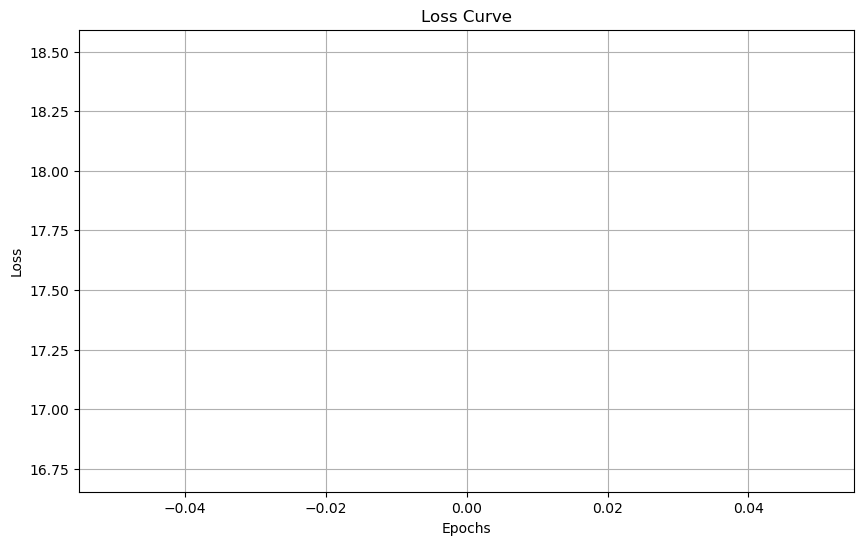

1/1 [==============================] - 0s 495ms/step


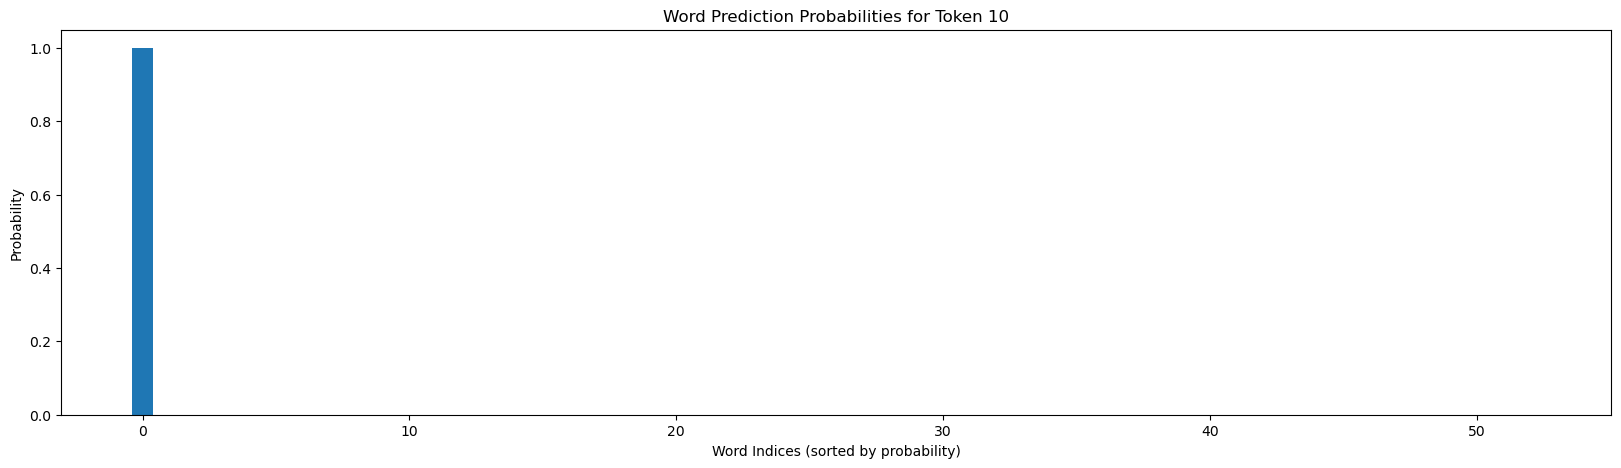

tf.Tensor([32 67 18 68 69 19 70 33 71 10], shape=(10,), dtype=int32)
tf.Tensor([ 0 14  2 15  2 16  5  2 17  5], shape=(10,), dtype=int32)
1/1 [==============================] - 0s 64ms/step
Predicted sequence:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Predicted text:  ['UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK U

In [34]:

# Block 10
# Evaluation Class

class Evaluator:
    def __init__(self, model, loader):
        self.model = model
        self.loader = loader

    def plot_loss(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def plot_token_probabilities(self, token_index, n_samples):
        # Get n_samples from the dataset
        for (encoder_input, decoder_input), _ in self.loader.dataset.take(n_samples):
            prediction = self.model.predict([encoder_input, decoder_input])
            token_logits = prediction[0, token_index]

            # Convert logits to probabilities
            token_probabilities = tf.nn.softmax(token_logits).numpy()

            sorted_indices = np.argsort(token_probabilities)[::-1]
            sorted_probabilities = token_probabilities[sorted_indices]

            plt.figure(figsize=(20, 5))
            plt.bar(range(len(sorted_probabilities)), sorted_probabilities)
            plt.xlabel('Word Indices (sorted by probability)')
            plt.ylabel('Probability')
            plt.title(f'Word Prediction Probabilities for Token {token_index}')
            plt.show()

    def generate_sample_predictions(self, n_samples=1):
        # Get n_samples from the dataset
        for (encoder_input, decoder_input), _ in self.loader.dataset.take(n_samples):
            print(encoder_input[1][:10])
            print(decoder_input[1][:10])
            prediction = self.model.predict([encoder_input, decoder_input])
            predicted_sequence = np.argmax(prediction, axis=-1)
            predicted_text = self.loader.solution_tokenizer.sequences_to_texts(predicted_sequence)

            print("Predicted sequence: ", predicted_sequence)
            print("Predicted text: ", predicted_text)

    def evaluate(self, command, *args, **kwargs):
        if command == 'loss':
            self.plot_loss(*args, **kwargs)
        elif command == 'token_prob':
            self.plot_token_probabilities(*args, **kwargs)
        elif command == 'sample_pred':
            self.generate_sample_predictions(*args, **kwargs)
        else:
            print(f"Unknown command: {command}")

# Load the model if it's not
model = tf.keras.models.load_model('/workspace')

# Uncomment what you want to run
evaluator = Evaluator(model, loader)
evaluator.evaluate('loss', history)
evaluator.evaluate('token_prob', token_index=10, n_samples=4)
evaluator.evaluate('sample_pred', n_samples=4)


In [ ]:
!tensorboard --logdir logs --bind_all

2024-01-25 01:05:56.331274: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 01:05:56.352831: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 01:05:56.352865: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 01:05:56.352899: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 01:05:56.356823: I tensorflow/core/platform/cpu_feature_g

In [ ]:
print("hello")